# Analysis of Entire Funnel (using R)
## All Steps

In [2]:
#0: Import Libraries
library(rpart)
library(rpart.plot)
library(randomForest)
library(htmlTable)
library(Gmisc)
library(rattle)
library(gbm)
library(ROCR)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: Rcpp
Rattle: A free graphical interface for data mining with R.
Version 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## Load Data

In [3]:
infilename = "Data/derived_data/funnel_steps_20161006.csv"

In [4]:
## load dataframe from csv
fii <- read.csv(infilename)


fii$funnel.exposure = fii$funnel.exposure == 'True'
fii$funnel.enrollment = fii$funnel.enrollment == 'True'
fii$funnel.usage = fii$funnel.usage == 'True'
fii$funnel.usage_basic = fii$funnel.usage_basic == 'True'
fii$funnel.usage_sophisticated = fii$funnel.usage_sophisticated == 'True'
fii$funnel.recent = fii$funnel.recent == 'True'
fii$funnel.longevity = fii$funnel.longevity == 'True'
fii$funnel.frequent = fii$funnel.frequent == 'True'
fii$funnel.retention = fii$funnel.retention == 'True'

summary(fii)

       X            country          age            gender      marital_status 
 Min.   :   0   kenya   :2994   Min.   :15.00   Min.   :1.000   Min.   :1.000  
 1st Qu.: 937   nigeria :6001   1st Qu.:24.00   1st Qu.:1.000   1st Qu.:1.000  
 Median :1874   tanzania:3001   Median :30.00   Median :2.000   Median :3.000  
 Mean   :2099   uganda  :3000   Mean   :33.82   Mean   :1.526   Mean   :2.605  
 3rd Qu.:2811                   3rd Qu.:40.00   3rd Qu.:2.000   3rd Qu.:3.000  
 Max.   :6000                   Max.   :96.00   Max.   :2.000   Max.   :9.000  
                                NA's   :75                                     
 education_level  funnel.exposure funnel.enrollment funnel.usage_basic
 Min.   : 1.000   Mode :logical   Mode :logical     Mode :logical     
 1st Qu.: 3.000   FALSE:6416      FALSE:9063        FALSE:9293        
 Median : 4.000   TRUE :8580      TRUE :5933        TRUE :5703        
 Mean   : 4.402   NA's :0         NA's :0           NA's :0           
 3rd 

In [5]:
names(fii)

[1] "X"                          "country"                   
 [3] "age"                        "gender"                    
 [5] "marital_status"             "education_level"           
 [7] "funnel.exposure"            "funnel.enrollment"         
 [9] "funnel.usage_basic"         "funnel.usage_sophisticated"
[11] "funnel.usage"               "funnel.recent"             
[13] "funnel.longevity"           "funnel.frequent"           
[15] "funnel.retention"

## Set up Loop

In [6]:
names(fii)

[1] "X"                          "country"                   
 [3] "age"                        "gender"                    
 [5] "marital_status"             "education_level"           
 [7] "funnel.exposure"            "funnel.enrollment"         
 [9] "funnel.usage_basic"         "funnel.usage_sophisticated"
[11] "funnel.usage"               "funnel.recent"             
[13] "funnel.longevity"           "funnel.frequent"           
[15] "funnel.retention"

In [7]:
get_settings <- function(selected_country, funnel_step){
    if (funnel_step == 'Exposure') {
        # Exposure
        # from all respondants
        col = 'funnel.exposure'
        mask = (fii$country==selected_country)
    } else if (funnel_step == 'Enrollment') {
        # Enrollment
        # From Exposure
        col = 'funnel.enrollment'
        mask = (fii$country==selected_country) & (fii$funnel.exposure)
    } else if (funnel_step == 'Usage: Basic') {
        # Usage Basic
        # From Enrollment
        col = 'funnel.usage_basic'
        mask = (fii$country==selected_country) & (fii$funnel.enrollment)            
    } else if (funnel_step == 'Usage: Sophisticated') {
        # Usage Sophisticated 
        # from Usage Basic
        col = 'funnel.usage_sophisticated'
        mask = (fii$country==selected_country) & (fii$funnel.usage_basic)
    } else if (funnel_step == 'Retention') {
        # Retention            
        # From Usage (any)
        col = 'funnel.retention'
        mask = (fii$country==selected_country) & (fii$funnel.usage)
    } else if (funnel_step == 'Retention (from sophisticated usage)') {
        # Retention 
        # From Sophisticated Usage
        col = 'funnel.retention'
        mask = (fii$country==selected_country) & (fii$funnel.usage_sophisticated)
    } else print("Invalid")
        
    return(list("col"=col, "mask"=mask))
}


In [16]:
# This is a test loop

all_countries = c('kenya', 'uganda', 'tanzania')

all_funnel_steps = c('Exposure', 'Enrollment', 
                     'Usage: Basic', 'Usage: Sophisticated', 
                     'Retention', 'Retention (from sophisticated usage)')

for (selected_country in all_countries){
    # print(paste("Country:", selected_country))
    
    for (funnel_step in all_funnel_steps){
        # Get settings for this {country, funnel step}
        # with(get_settings(selected_country, funnel_step), col, mask)
        vals = get_settings(selected_country, funnel_step)
        col = vals$col
        mask = vals$mask
        print(paste("Funnel Step:", col, "for", selected_country))
        
        # Apply Mask
        x_cols = c('age', 'gender', 'marital_status', 'education_level')
        keep_cols = c(x_cols, paste(col))
        dat <- fii[mask, keep_cols]
        print(nrow(dat))
        
        # do stuff here        
    }
        
}


[1] "Funnel Step: funnel.exposure for kenya"
[1] 2994
[1] "Funnel Step: funnel.enrollment for kenya"
[1] 2222
[1] "Funnel Step: funnel.usage_basic for kenya"
[1] 2452
[1] "Funnel Step: funnel.usage_sophisticated for kenya"
[1] 2423
[1] "Funnel Step: funnel.retention for kenya"
[1] 2423
[1] "Funnel Step: funnel.retention for kenya"
[1] 1401
[1] "Funnel Step: funnel.exposure for uganda"
[1] 3000
[1] "Funnel Step: funnel.enrollment for uganda"
[1] 2750
[1] "Funnel Step: funnel.usage_basic for uganda"
[1] 1411
[1] "Funnel Step: funnel.usage_sophisticated for uganda"
[1] 1381
[1] "Funnel Step: funnel.retention for uganda"
[1] 1381
[1] "Funnel Step: funnel.retention for uganda"
[1] 354
[1] "Funnel Step: funnel.exposure for tanzania"
[1] 3001
[1] "Funnel Step: funnel.enrollment for tanzania"
[1] 2660
[1] "Funnel Step: funnel.usage_basic for tanzania"
[1] 1995
[1] "Funnel Step: funnel.usage_sophisticated for tanzania"
[1] 1851
[1] "Funnel Step: funnel.retention for tanzania"
[1] 1852
[1] "Funn

## RPart

In [9]:
do_rpart_stuff <- function(funnel_step, country, col, dat){
    
    form <- paste(paste(col),"~.")
    tree <- rpart(
        formula = form, 
        data=dat,
        # cp=0.01
        )
    
    # fancyRpartPlot(tree)
    p <- fancyRpartPlot(
        tree, 
        main=paste(paste(funnel_step), "in", paste(country))
    )
    
    # barplot of variable importance
    #     options(repr.plot.width=5, repr.plot.height=3)
    #     barplot(
    #         sort(tree$variable.importance), 
    #         col=4, las=2, cex.names = .7, horiz=T, 
    #         main = paste("RPart Variable Importance Plot\n", col),
    #         sub=selected_country
    #     )
    
    # print out summary
    # summary(tree)


}


## Random Forest

In [10]:
do_forest_stuff <- function(funnel_step, country, col, dat){
    
    # Apply new Mask
    x_cols = c('age', 'gender', 'marital_status', 'education_level')
    keep_cols = c(x_cols, paste(col))
    #dat <- fii[mask, keep_cols]

    na_mask = complete.cases(dat[,keep_cols])
    na_dat <- dat[na_mask, keep_cols]
    
    # create RF
    forest <- randomForest(
        x=na_dat[,x_cols],
        y=as.factor(na_dat[,col]),
        type=classification,
        #as.factor(col)~.,
        data=dat,
        cp=0.001)

    # Feature Importance plot for RF
    varImpPlot(
        forest, 
        main = paste("Random Forest Variable Importance Plot\n", funnel_step, " ", country),
        col=4, 
        sub=country)
    
    # summary 
    # summary(forest)
   
}


# Execution Loop

[1] "Funnel Step: funnel.exposure for kenya"


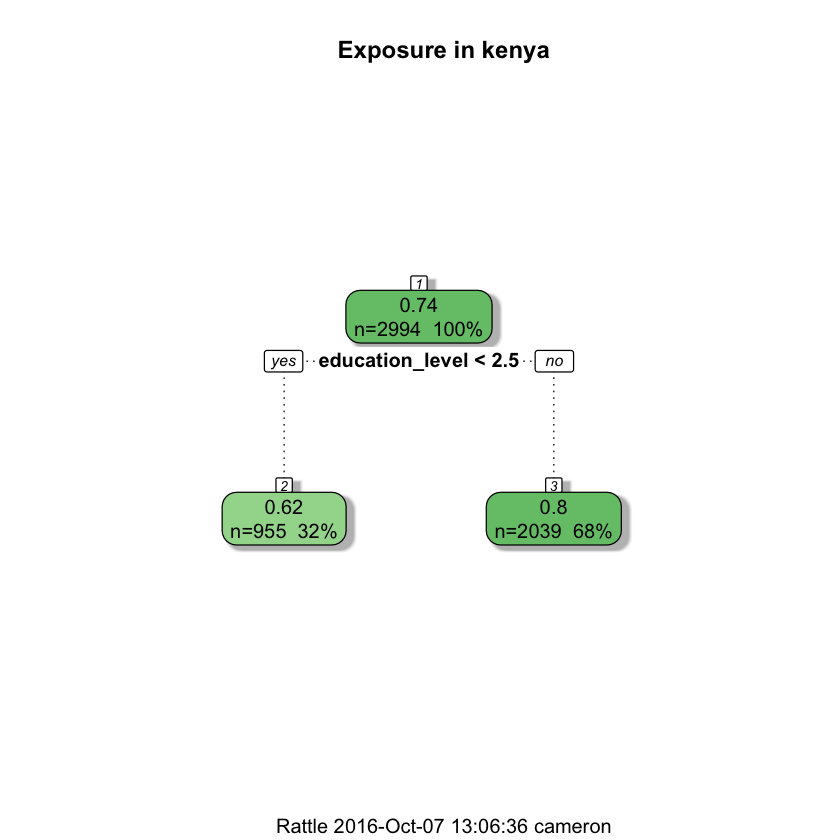

[1] "Funnel Step: funnel.enrollment for kenya"


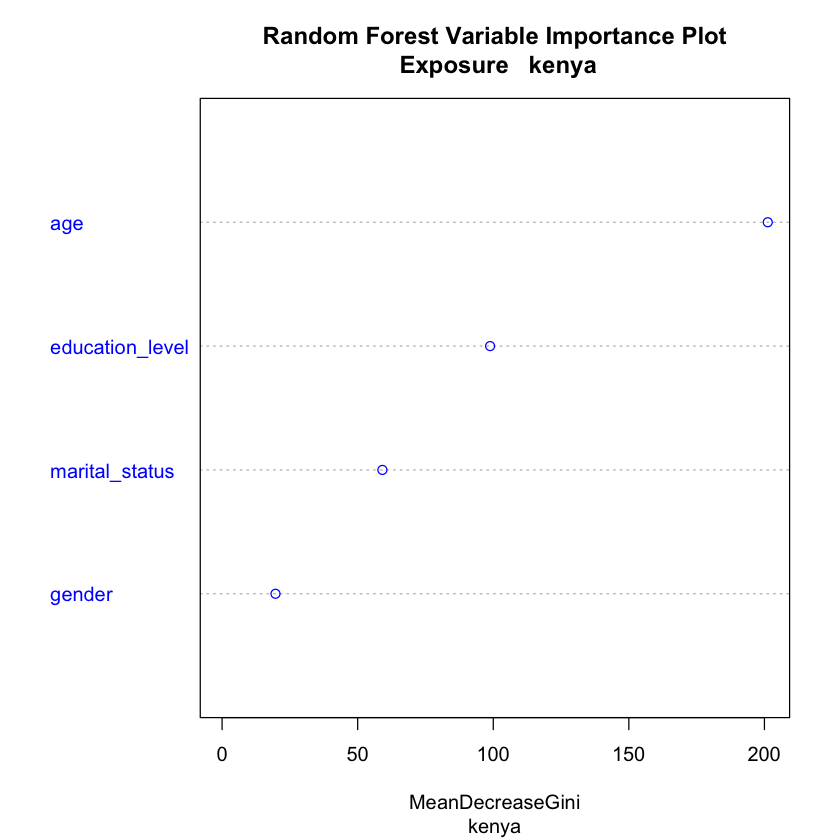

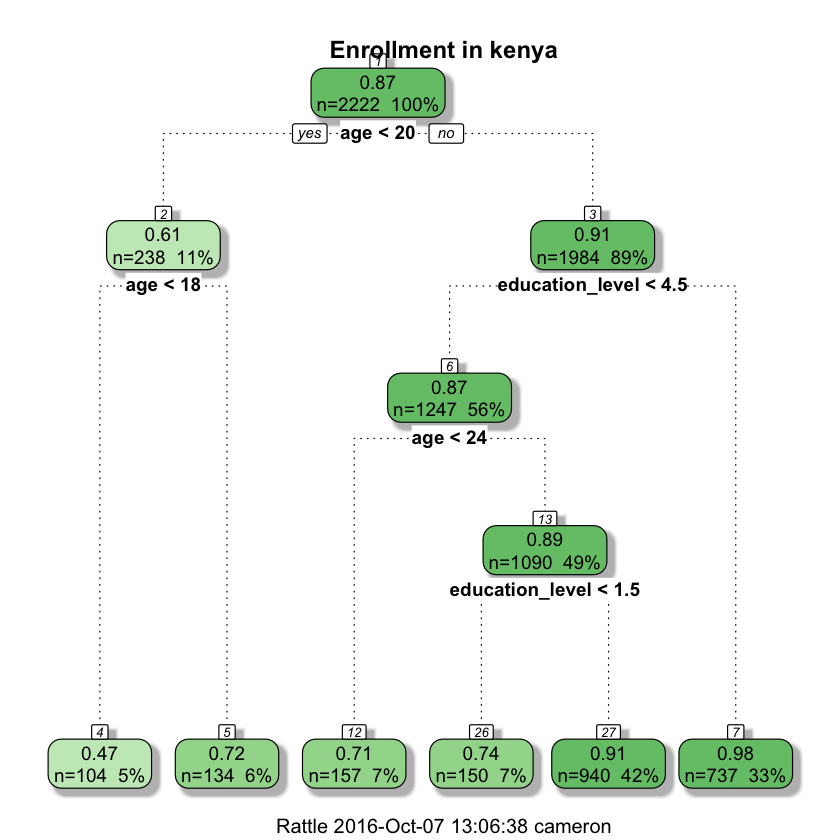

[1] "Funnel Step: funnel.usage_basic for kenya"


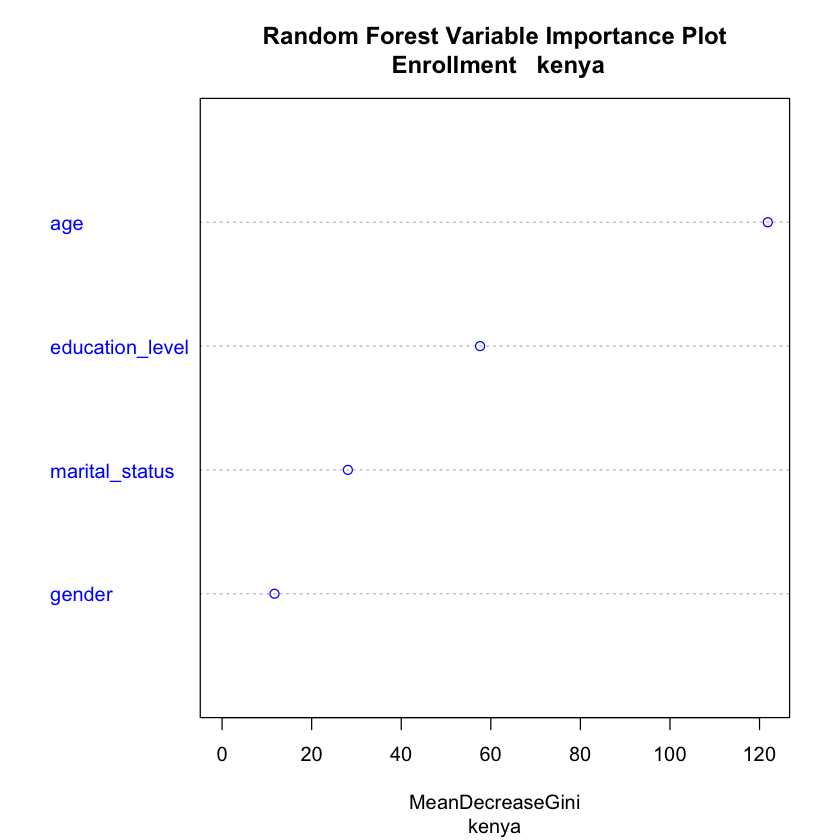

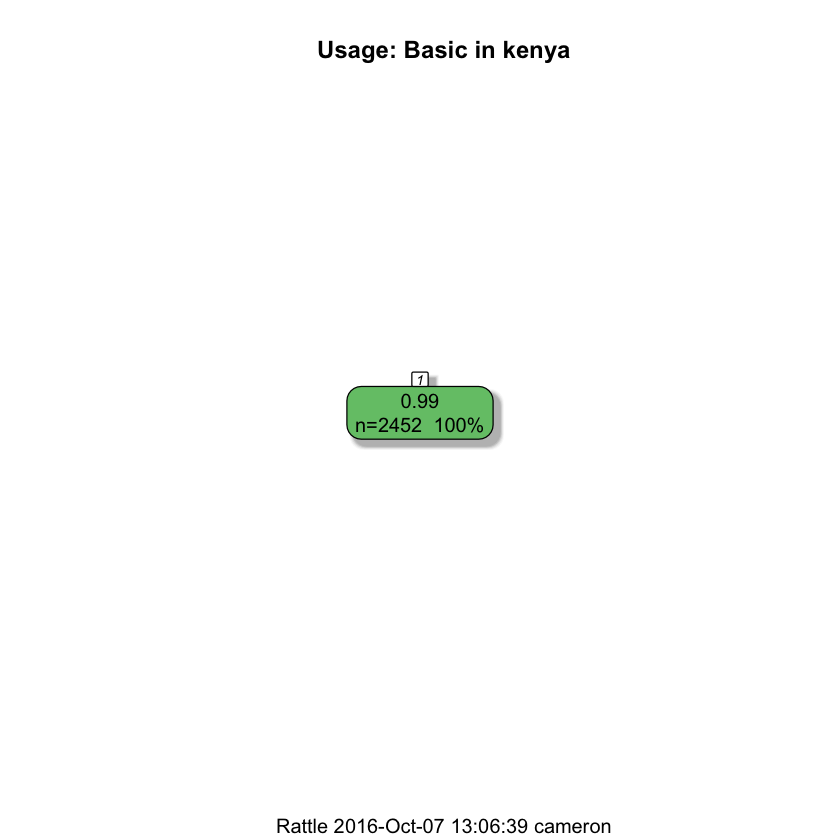

[1] "Funnel Step: funnel.usage_sophisticated for kenya"


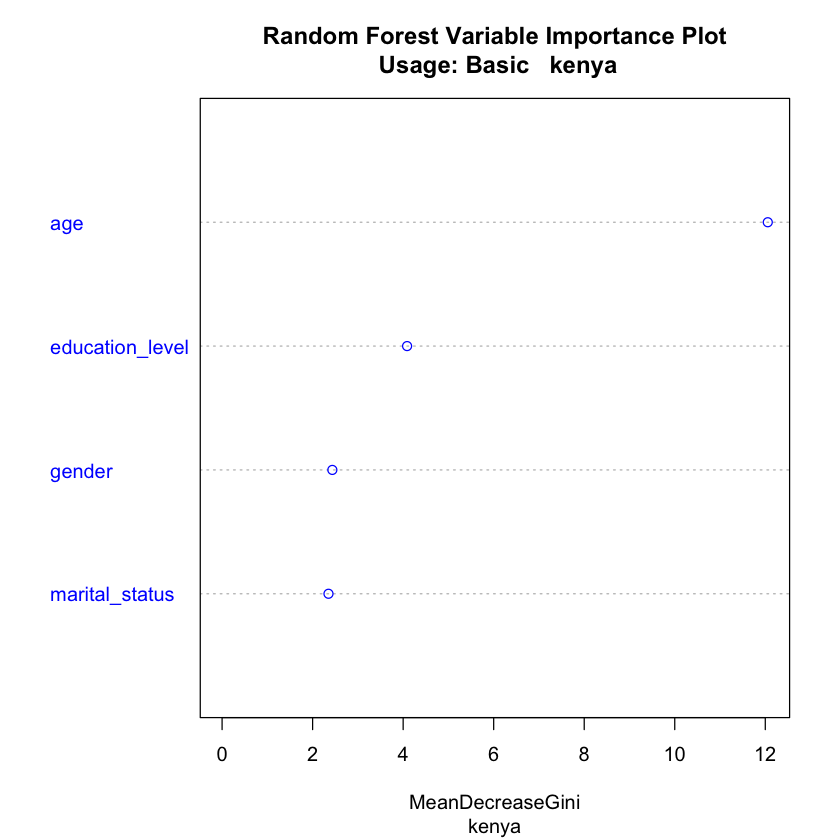

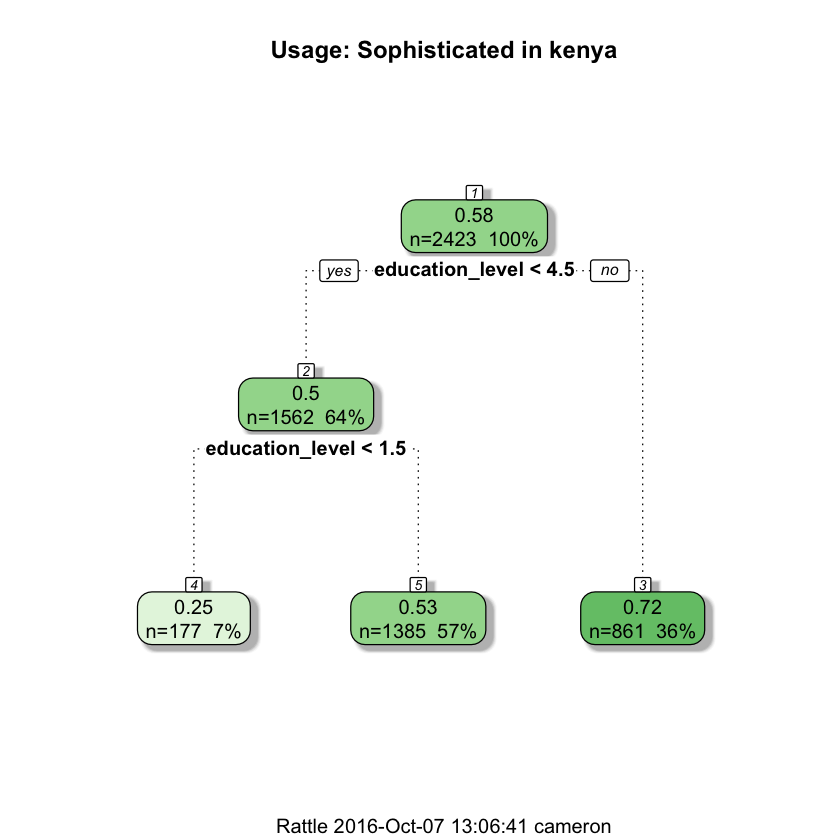

[1] "Funnel Step: funnel.retention for kenya"


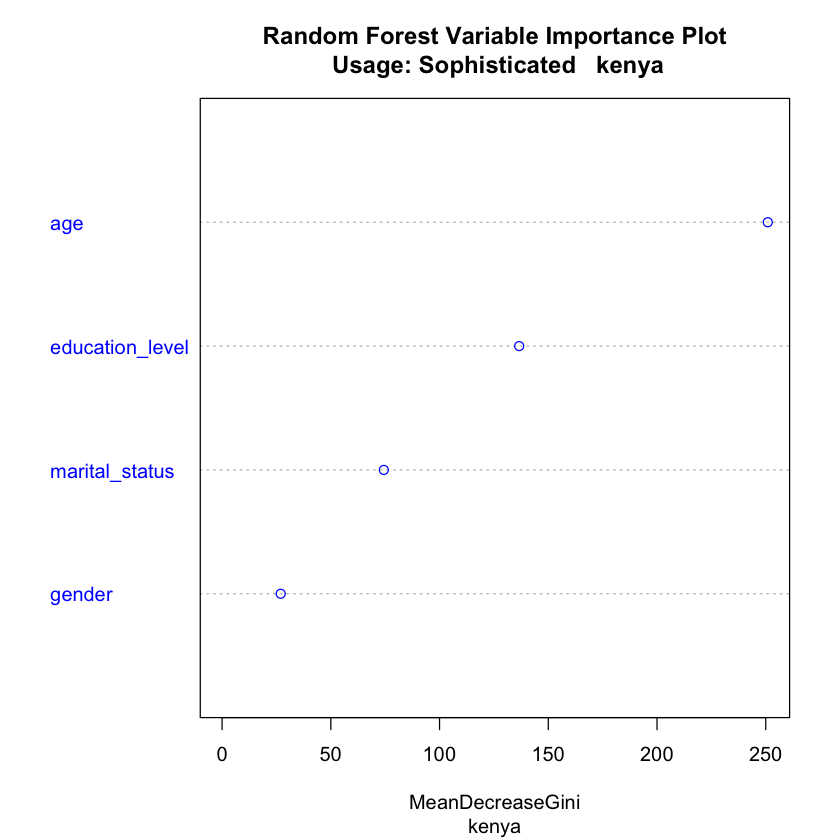

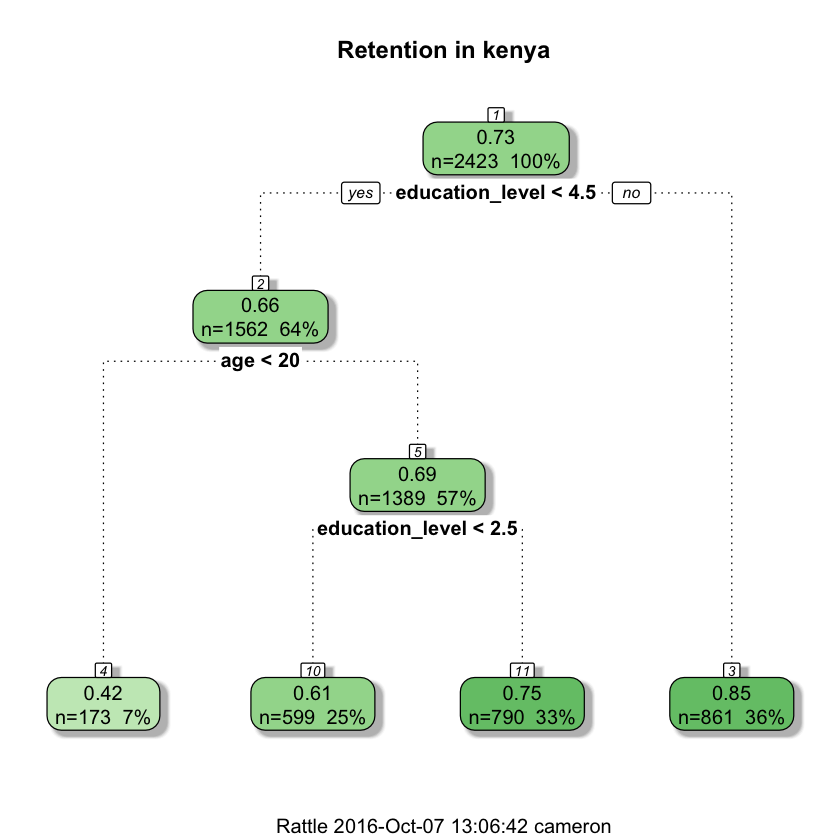

[1] "Funnel Step: funnel.retention for kenya"


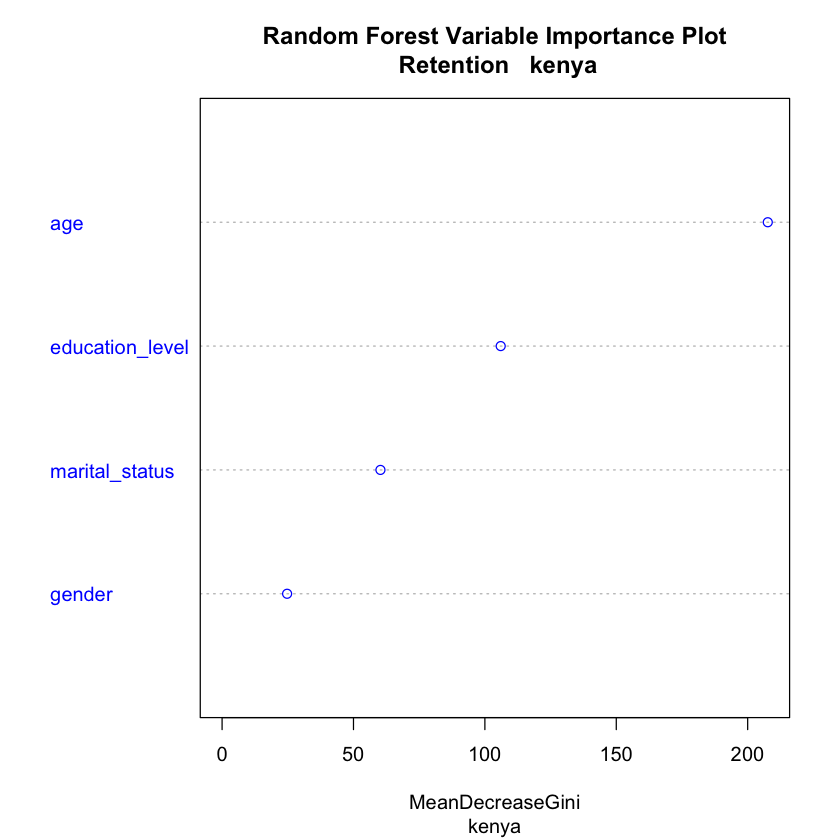

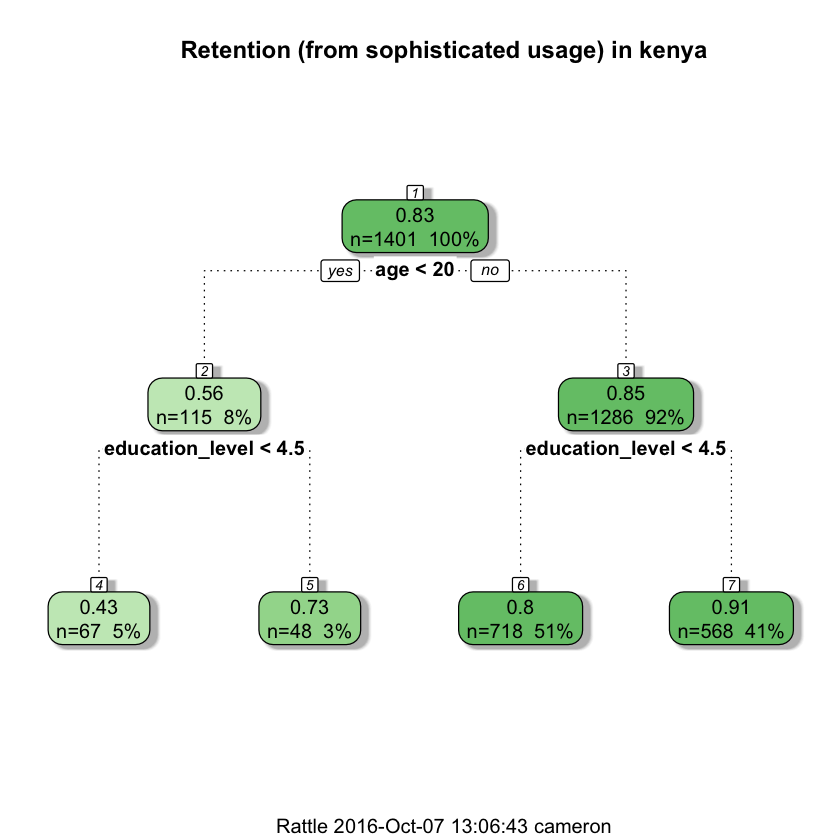

[1] "Funnel Step: funnel.exposure for uganda"


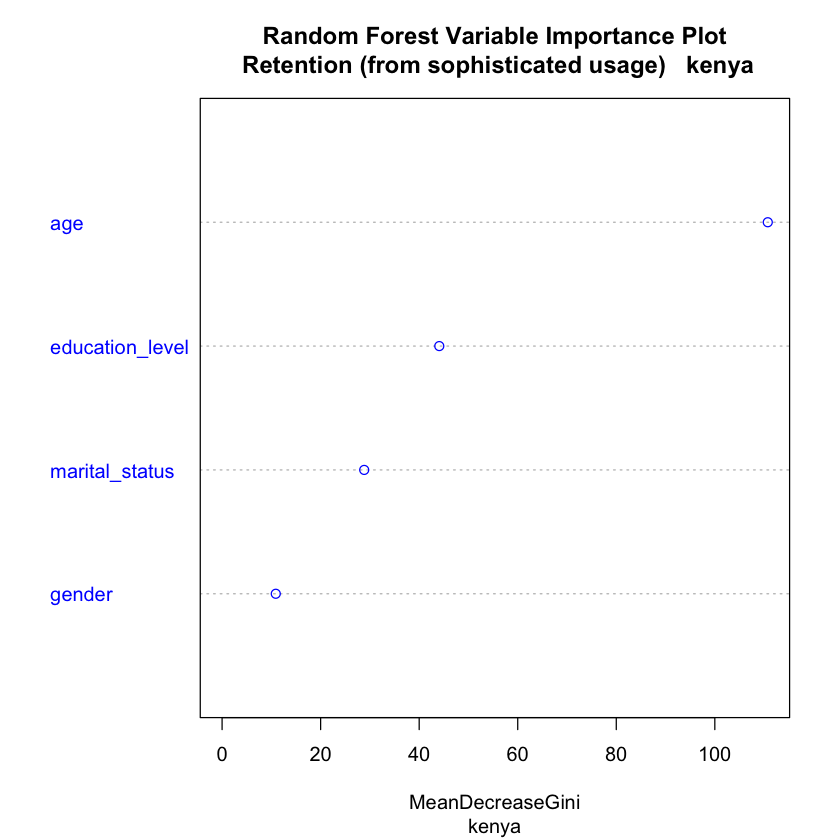

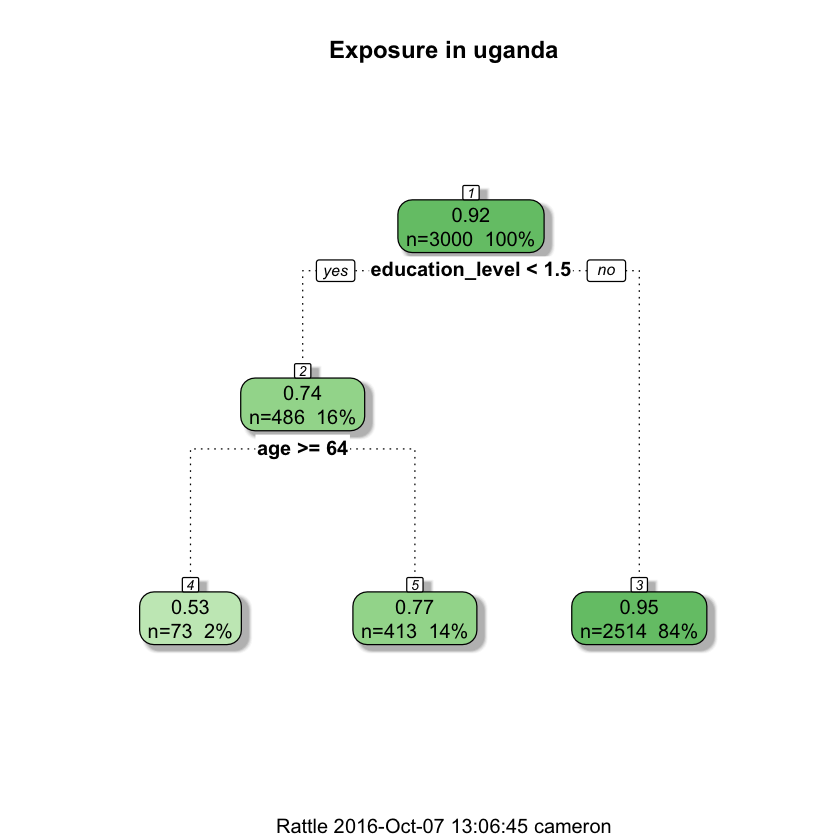

[1] "Funnel Step: funnel.enrollment for uganda"


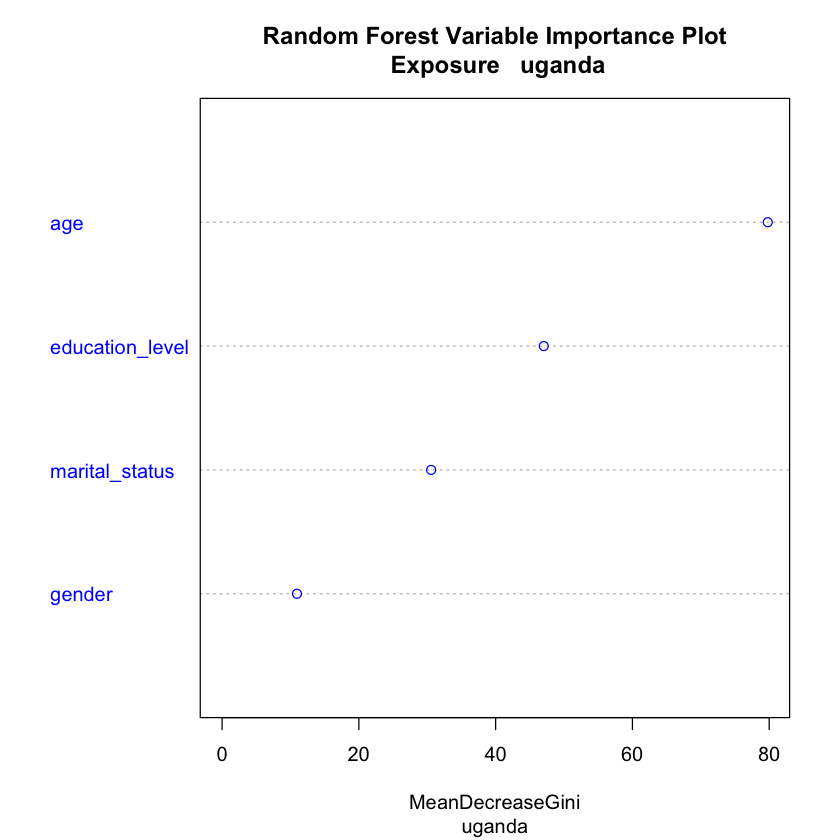

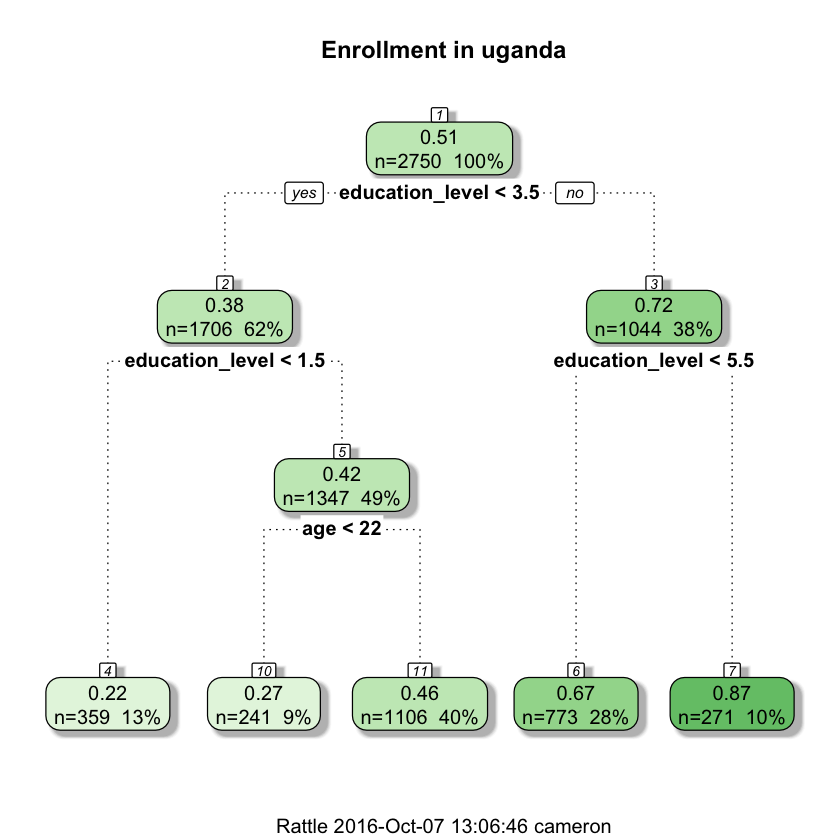

[1] "Funnel Step: funnel.usage_basic for uganda"


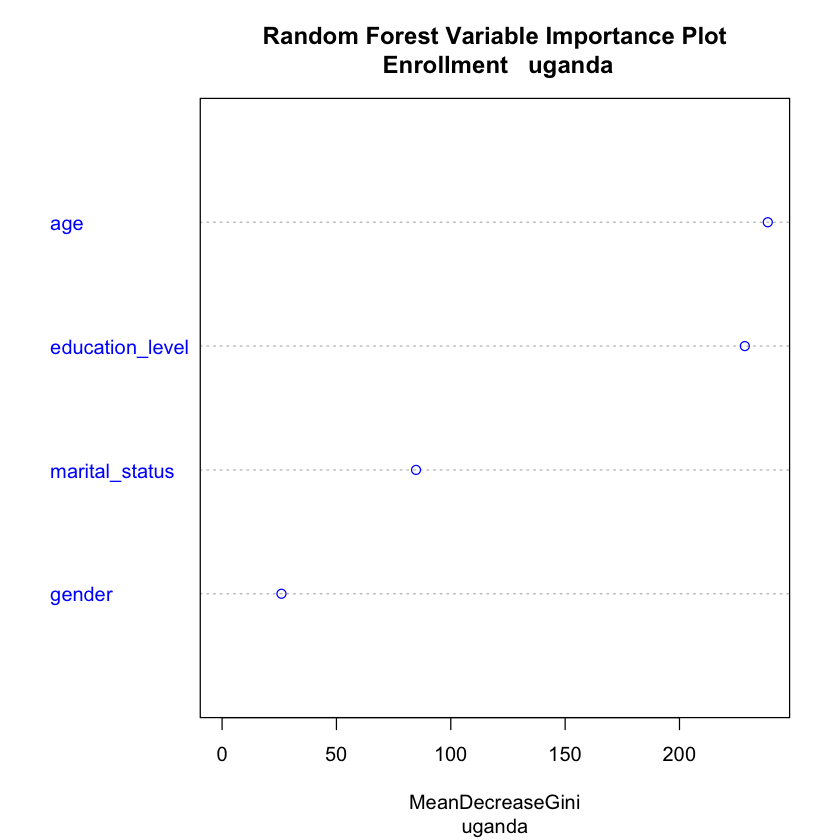

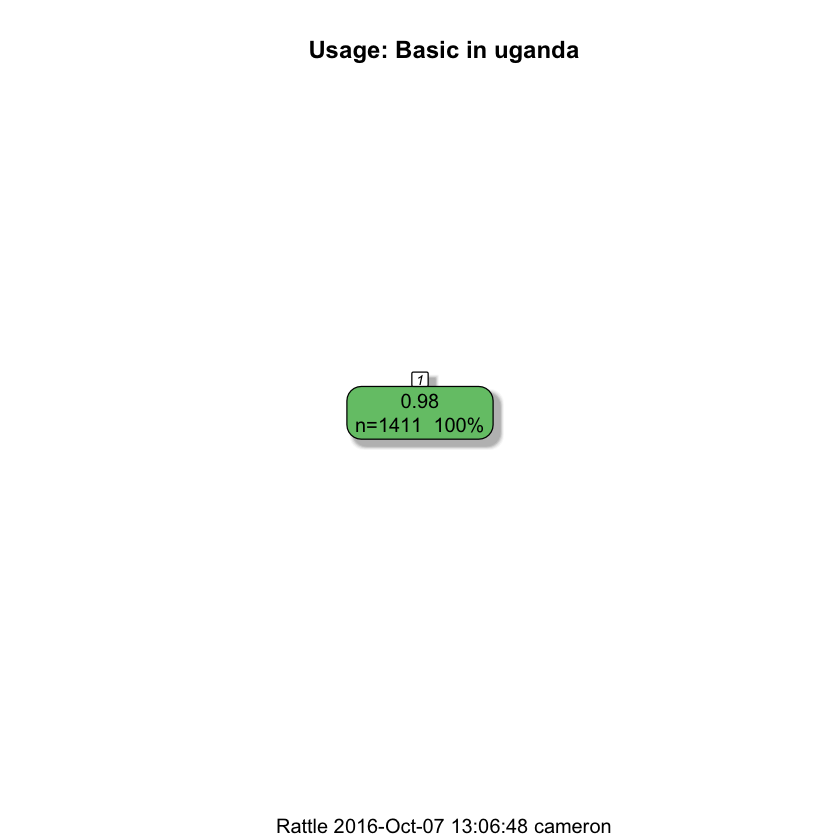

[1] "Funnel Step: funnel.usage_sophisticated for uganda"


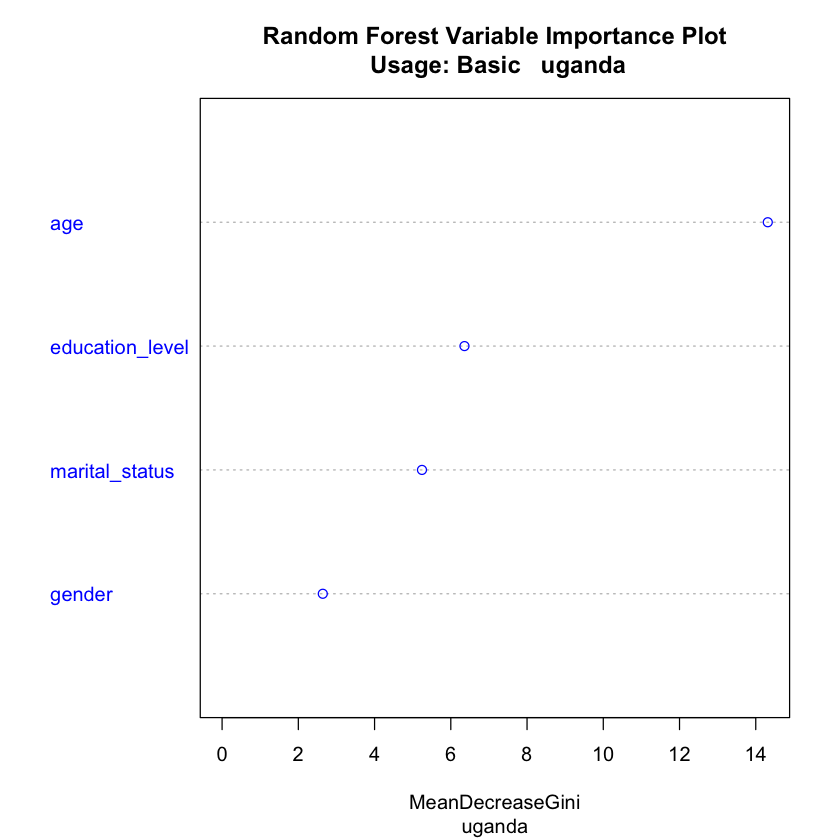

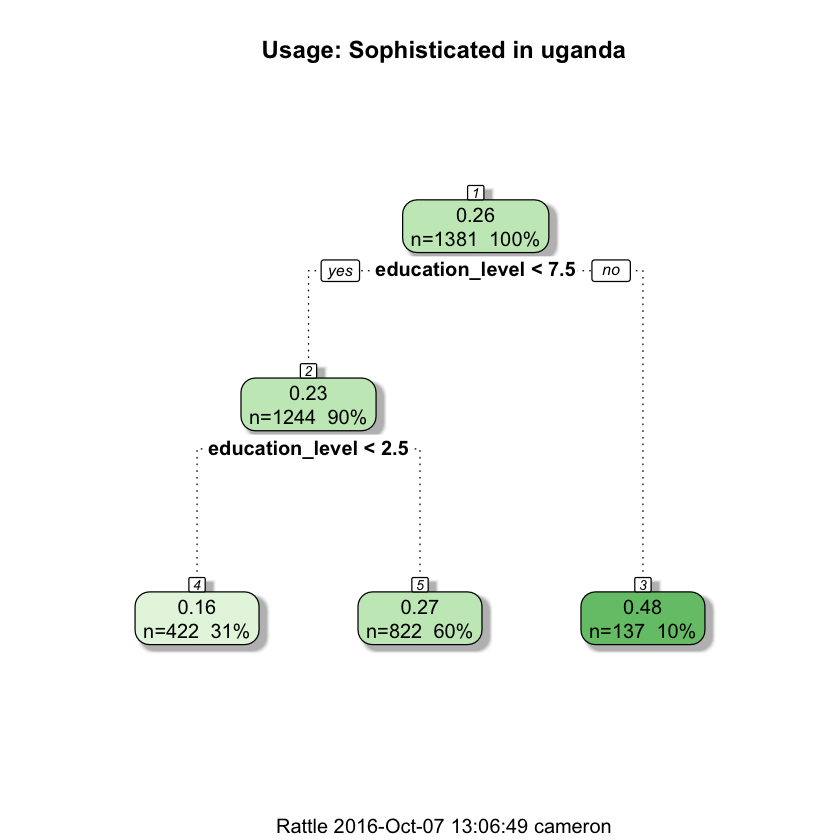

[1] "Funnel Step: funnel.retention for uganda"


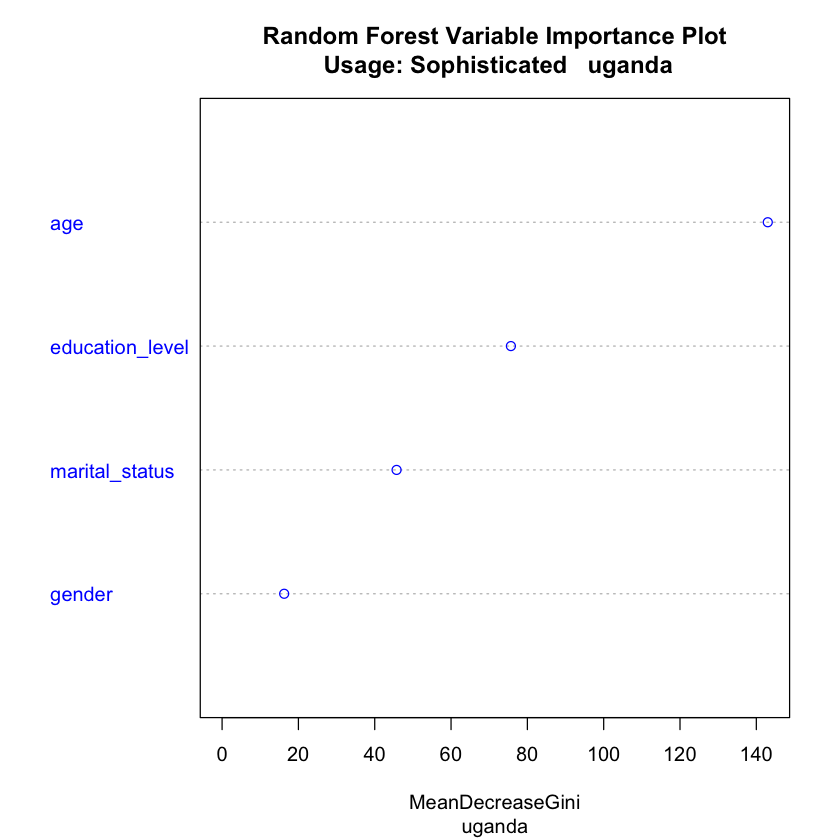

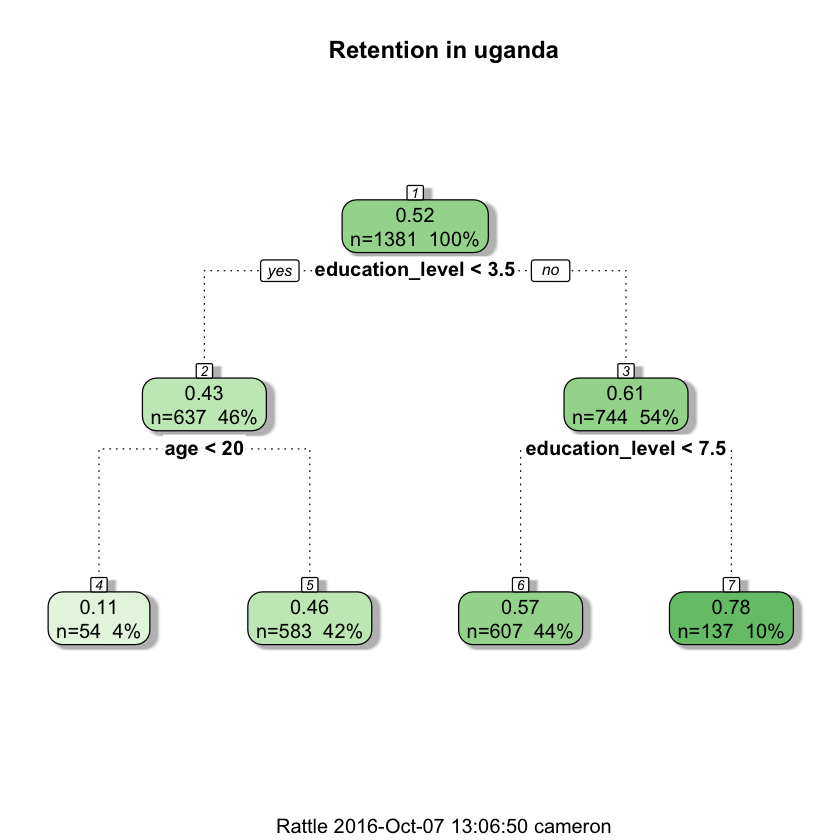

[1] "Funnel Step: funnel.retention for uganda"


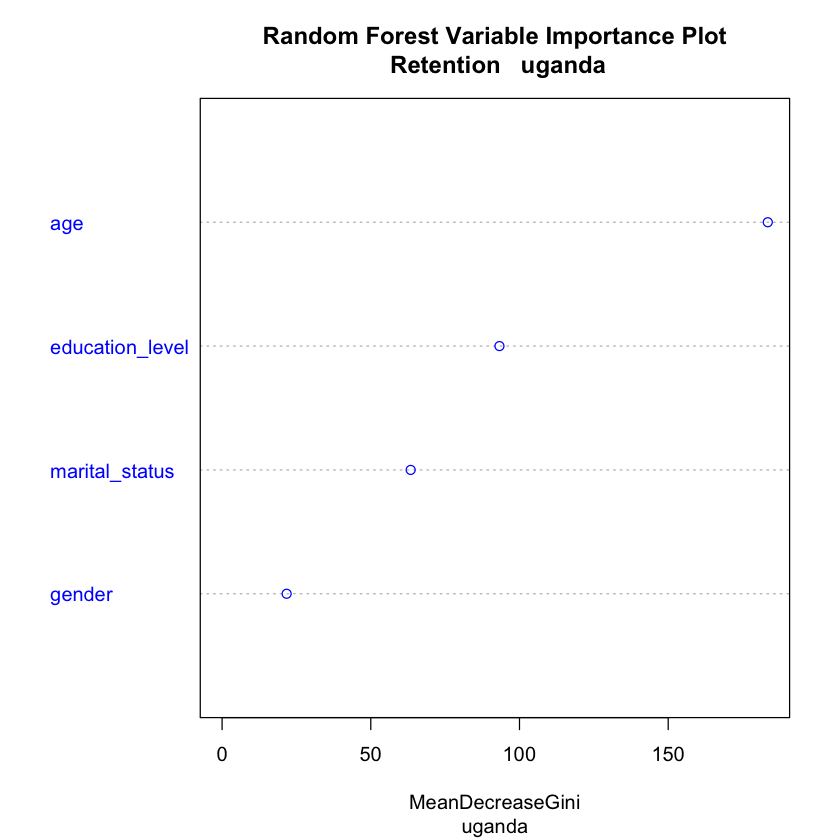

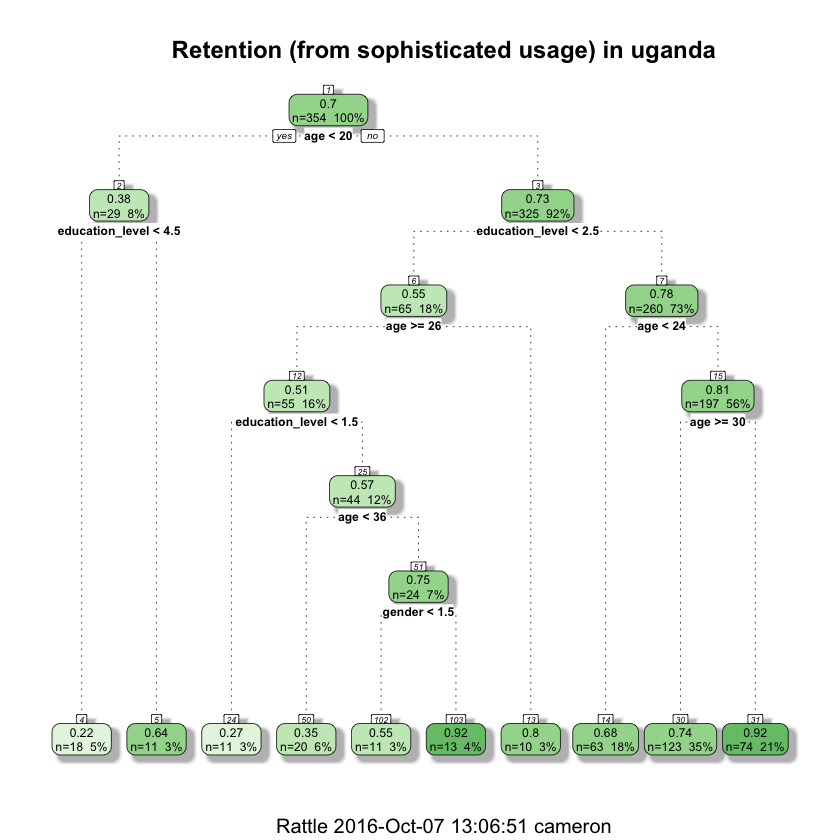

[1] "Funnel Step: funnel.exposure for tanzania"


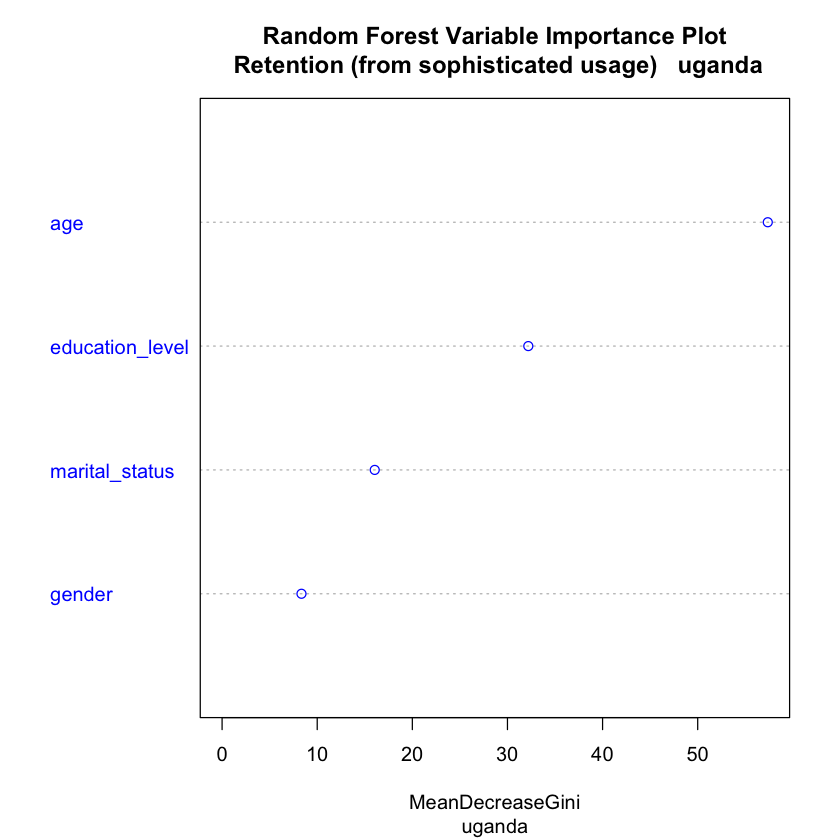

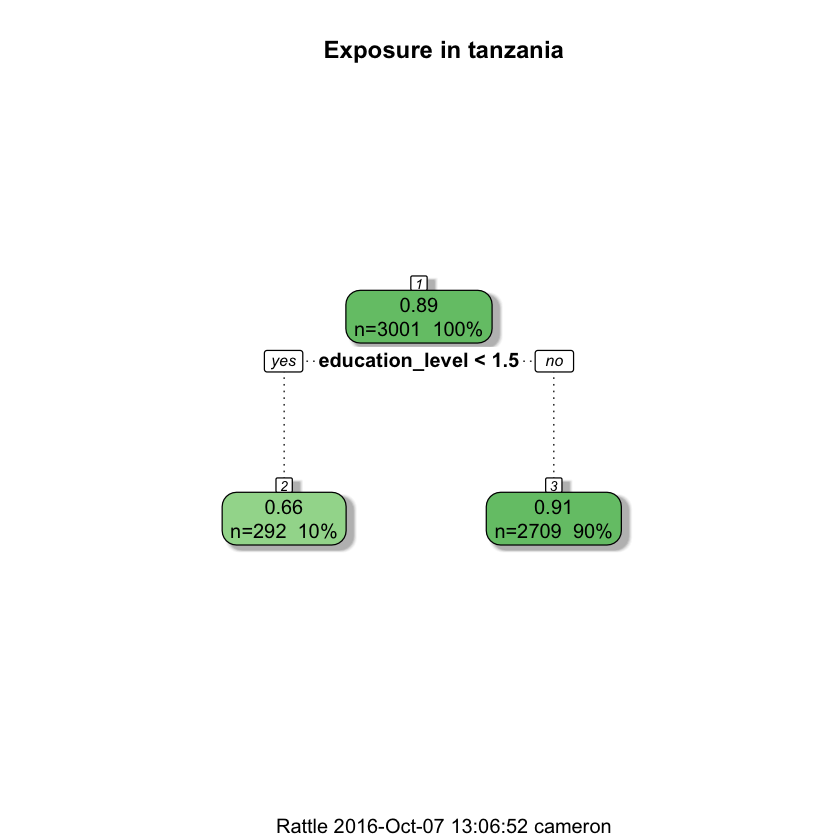

[1] "Funnel Step: funnel.enrollment for tanzania"


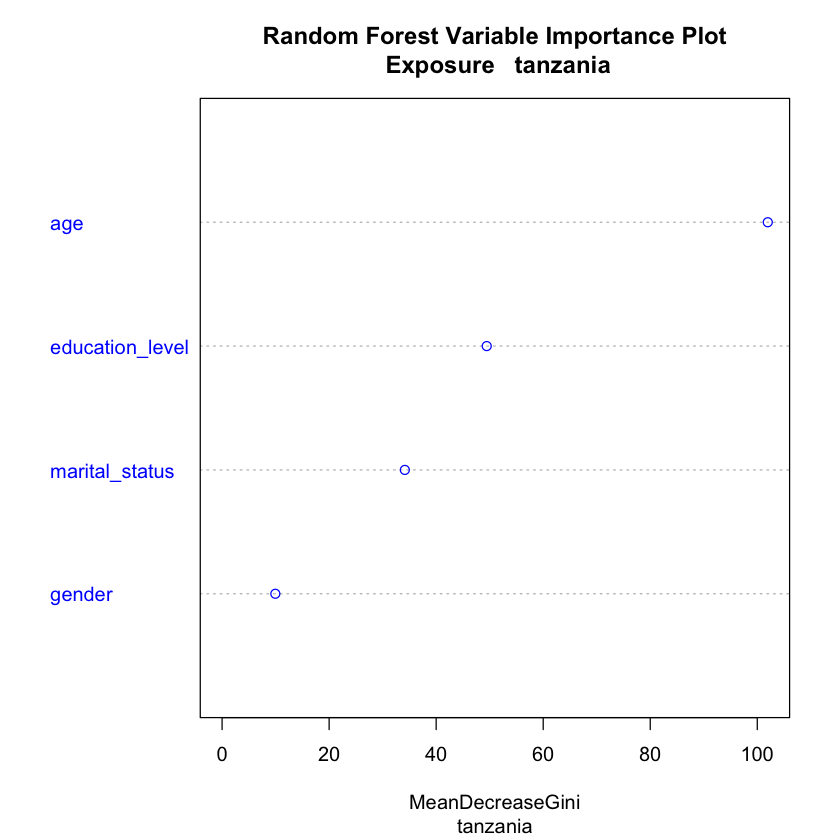

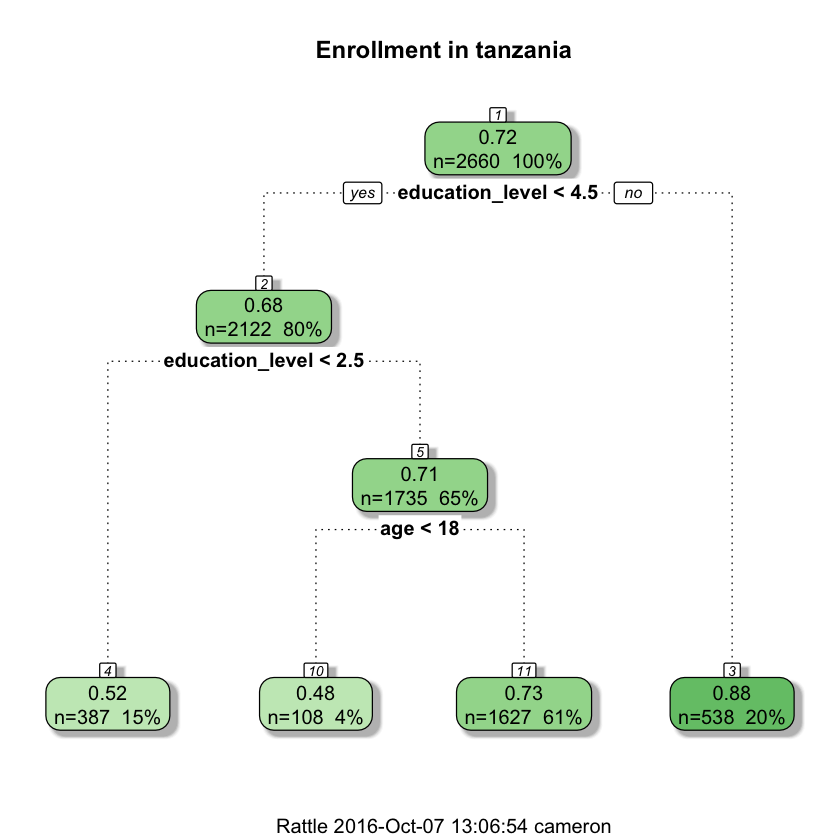

[1] "Funnel Step: funnel.usage_basic for tanzania"


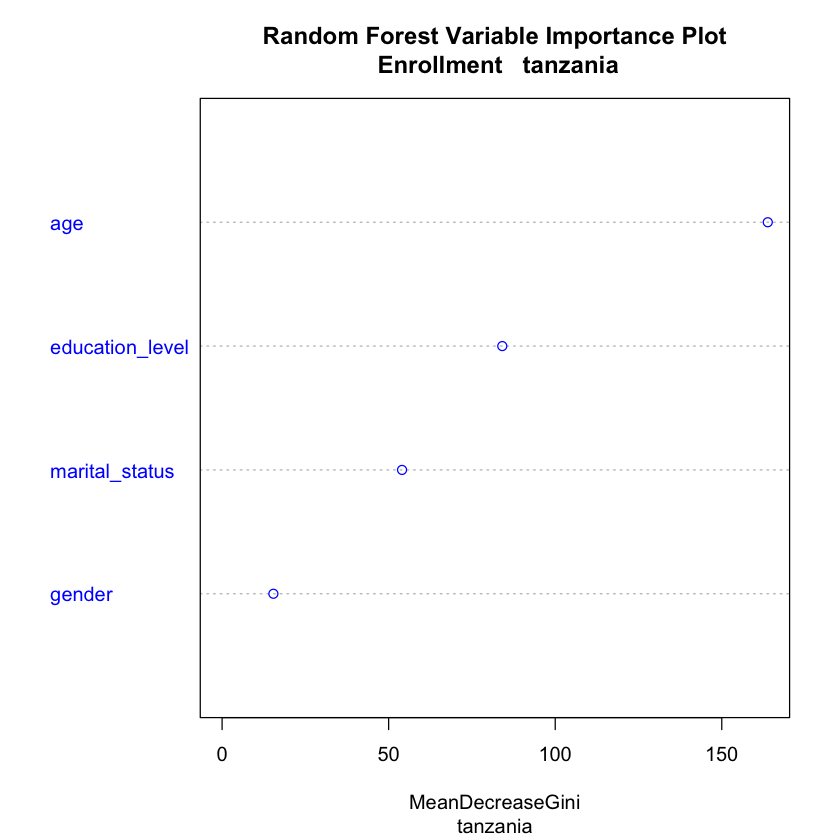

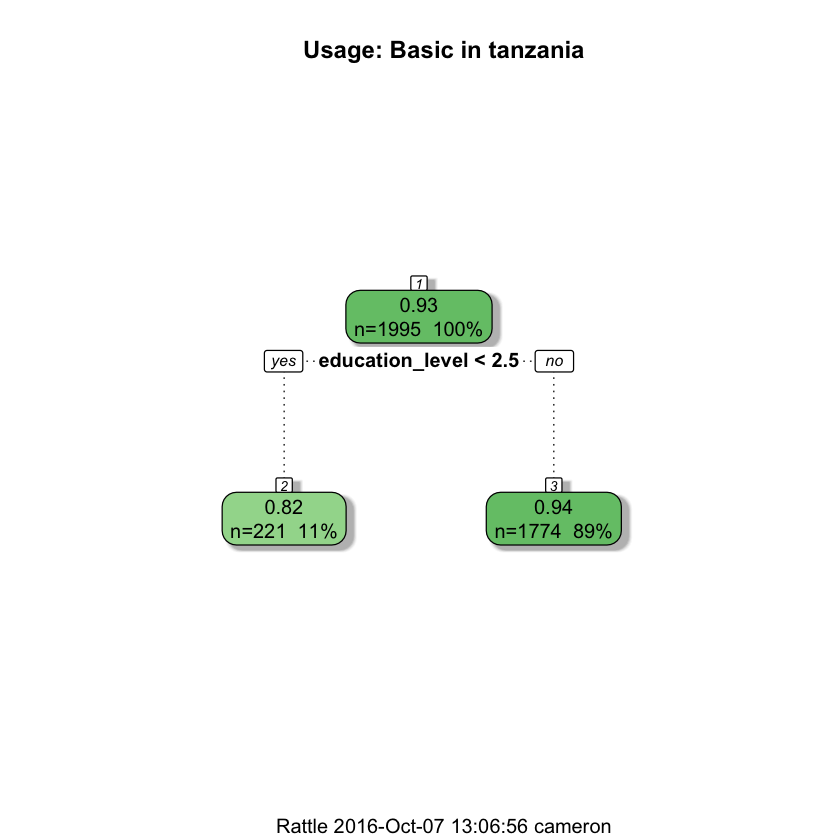

[1] "Funnel Step: funnel.usage_sophisticated for tanzania"


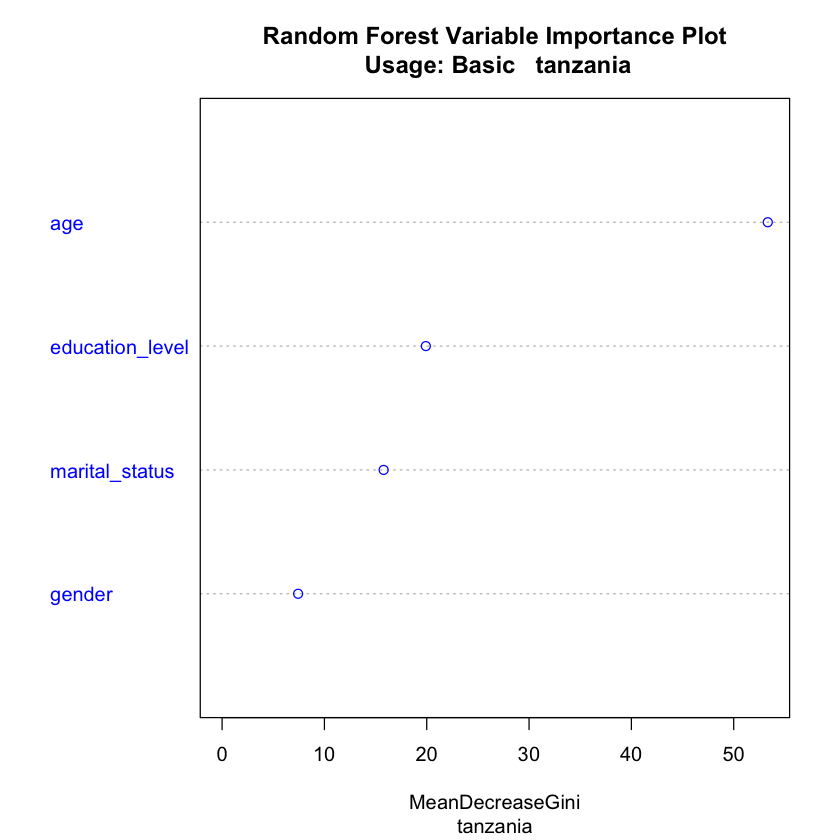

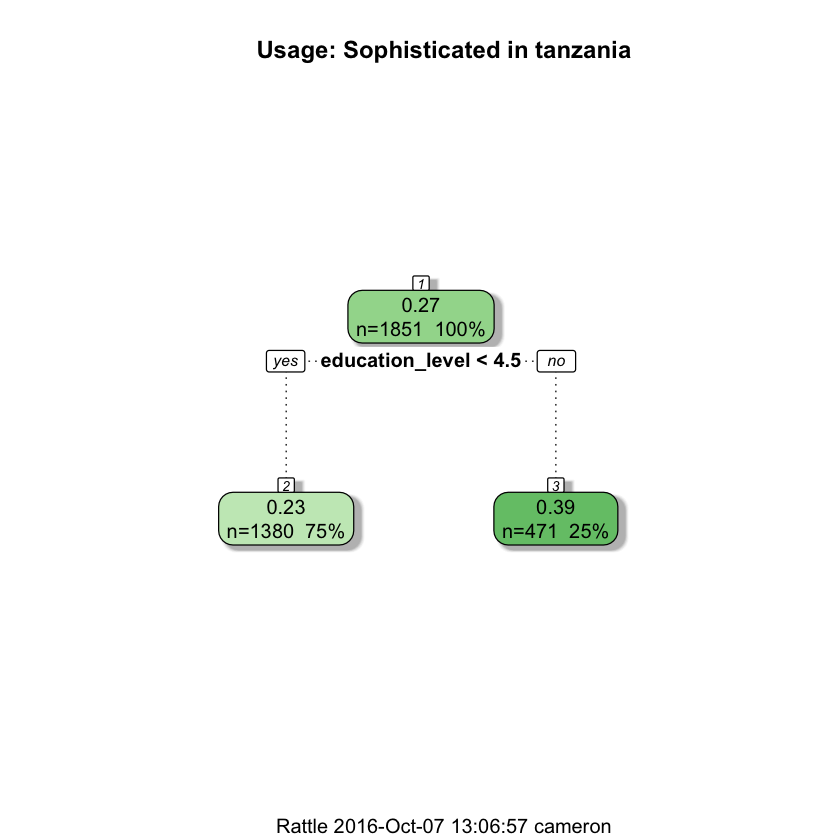

[1] "Funnel Step: funnel.retention for tanzania"


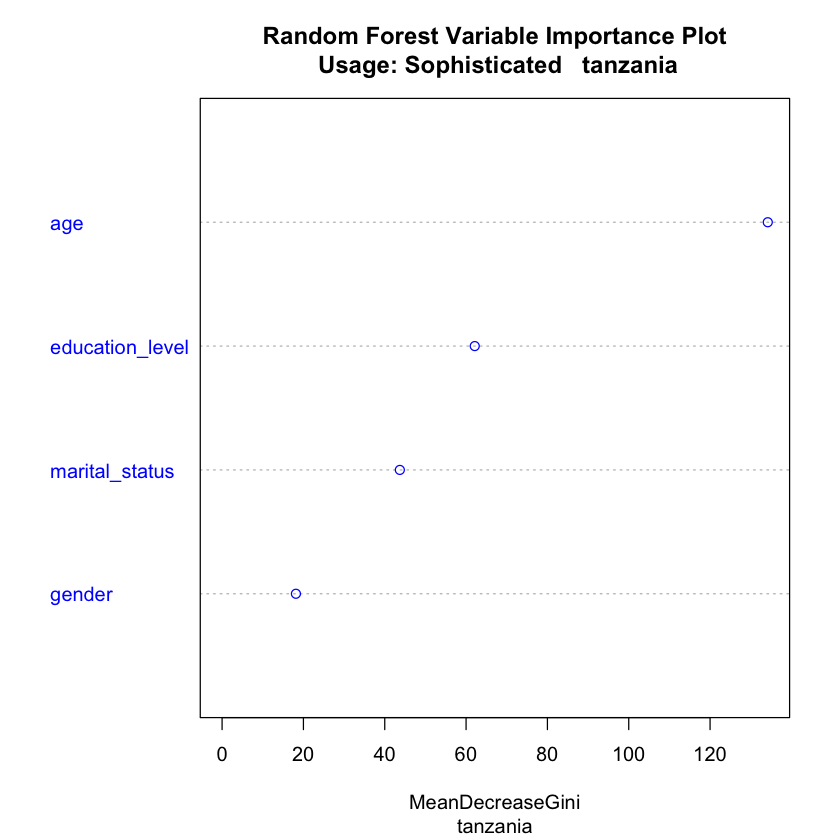

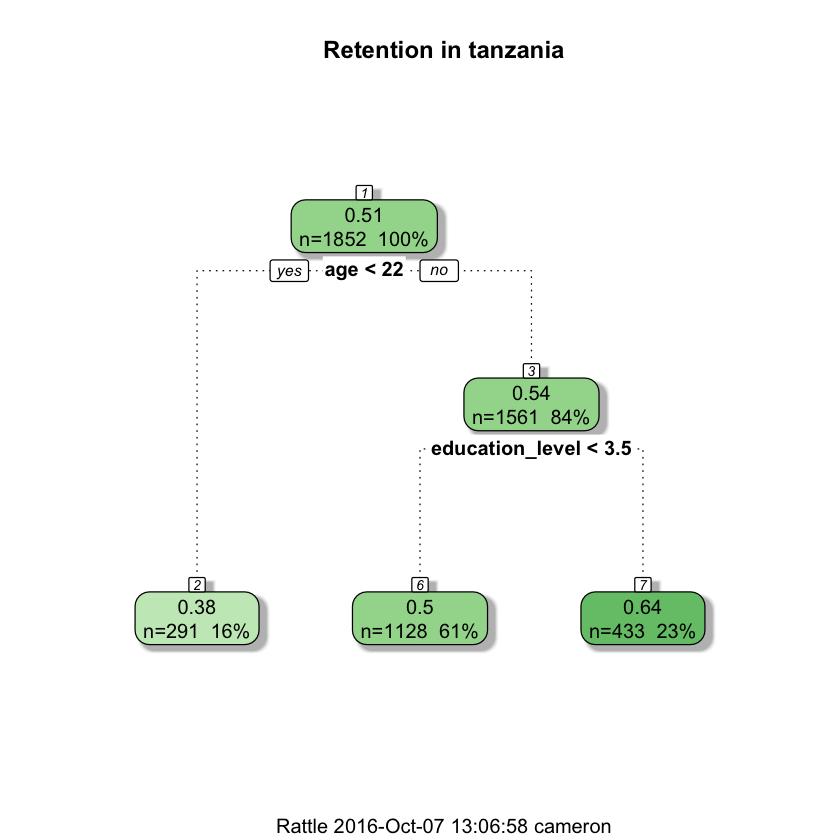

[1] "Funnel Step: funnel.retention for tanzania"


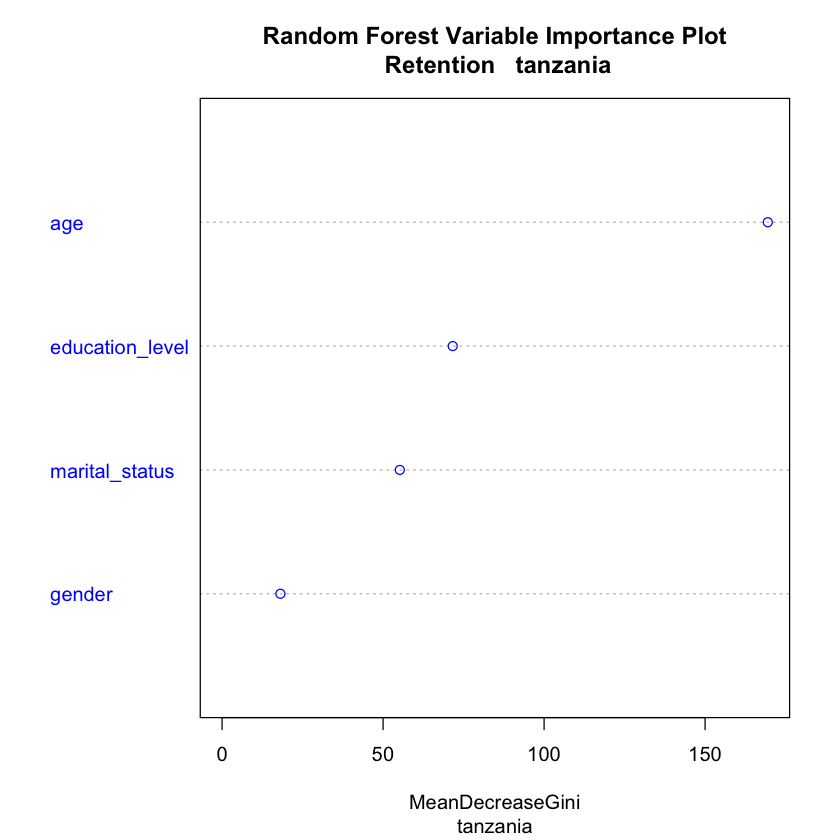

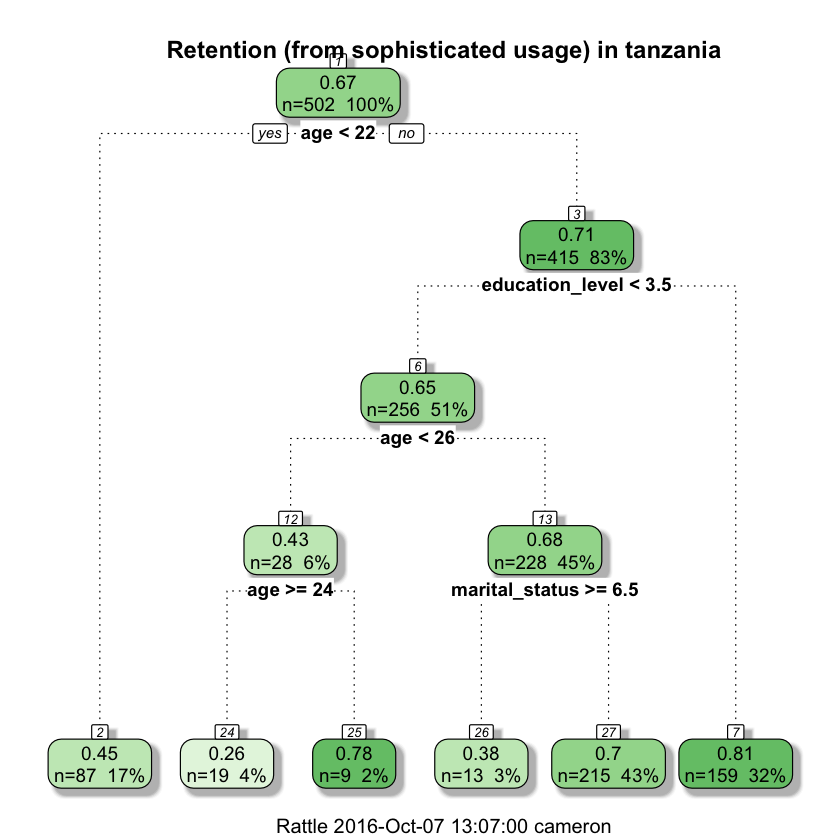

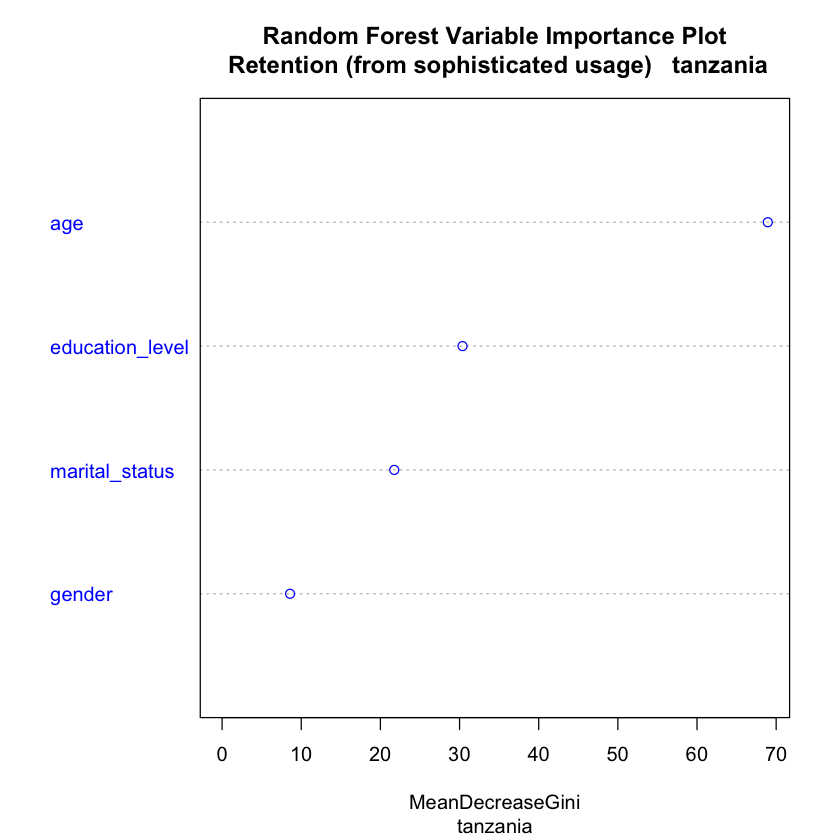

In [11]:
# This is the big loop

all_countries = c('kenya', 'uganda', 'tanzania')

all_funnel_steps = c('Exposure', 'Enrollment', 
                     'Usage: Basic', 'Usage: Sophisticated', 
                     'Retention', 'Retention (from sophisticated usage)')

for (selected_country in all_countries){
    # print(paste("Country:", selected_country))
    
    for (funnel_step in all_funnel_steps){
        # Get settings for this {country, funnel step}
        # with(get_settings(selected_country, funnel_step), col, mask)
        vals = get_settings(selected_country, funnel_step)
        col = vals$col
        mask = vals$mask
        print(paste("Funnel Step:", col, "for", selected_country))
        
        # Apply Mask
        x_cols = c('age', 'gender', 'marital_status', 'education_level')
        keep_cols = c(x_cols, paste(col))
        dat <- fii[mask, keep_cols]
        
        # do stuff here
        do_rpart_stuff(
            funnel_step = funnel_step,
            country=selected_country, 
            col=col, 
            dat=dat)
        
        do_forest_stuff(
            funnel_step = funnel_step,
            country=selected_country, 
            col=col, 
            dat=dat)
        
    }
        
}


# Below is scrap book of stuff from the other notebook

## Logistic Regression

In [13]:
summary(fii)

       X            country          age            gender      marital_status 
 Min.   :   0   kenya   :2994   Min.   :15.00   Min.   :1.000   Min.   :1.000  
 1st Qu.: 937   nigeria :6001   1st Qu.:24.00   1st Qu.:1.000   1st Qu.:1.000  
 Median :1874   tanzania:3001   Median :30.00   Median :2.000   Median :3.000  
 Mean   :2099   uganda  :3000   Mean   :33.82   Mean   :1.526   Mean   :2.605  
 3rd Qu.:2811                   3rd Qu.:40.00   3rd Qu.:2.000   3rd Qu.:3.000  
 Max.   :6000                   Max.   :96.00   Max.   :2.000   Max.   :9.000  
                                NA's   :75                                     
 education_level  funnel.exposure funnel.enrollment funnel.usage_basic
 Min.   : 1.000   Mode :logical   Mode :logical     Mode :logical     
 1st Qu.: 3.000   FALSE:6416      FALSE:9063        FALSE:9293        
 Median : 4.000   TRUE :8580      TRUE :5933        TRUE :5703        
 Mean   : 4.402   NA's :0         NA's :0           NA's :0           
 3rd 